# **Import Libraries**

In [139]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [140]:
base_path = '/kaggle/input/eurosat-dataset/EuroSAT'

# **Load CSVs**

In [141]:
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
val_df   = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df  = pd.read_csv(os.path.join(base_path, 'test.csv'))

train_df['Filename'] = train_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))
val_df['Filename']   = val_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))
test_df['Filename']  = test_df['Filename'].apply(lambda x: os.path.join(base_path, x.strip()))

# **Exploratory Data Analysis**

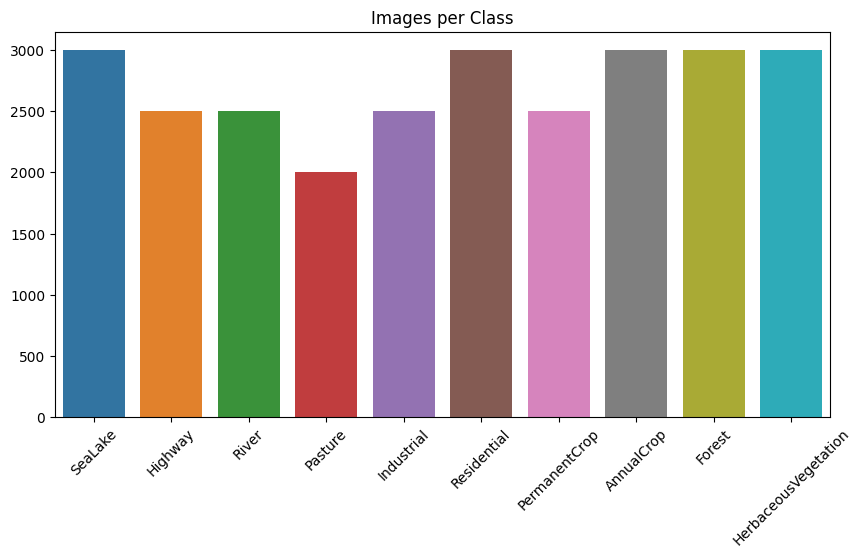

In [142]:
# Count images per class
class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))] 
class_counts = {cls: len(os.listdir(os.path.join(base_path, cls))) for cls in class_dirs}

plt.figure(figsize=(10, 5))

# Convert x to pd.Series; Removes warning of seaborn (Array)
sns.barplot(
    x=pd.Series(list(class_counts.keys())),
    y=list(class_counts.values())
)

plt.xticks(rotation=45)
plt.title("Images per Class")
plt.show()

# **Image Generators**

In [143]:
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filename',
    y_col='ClassName',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


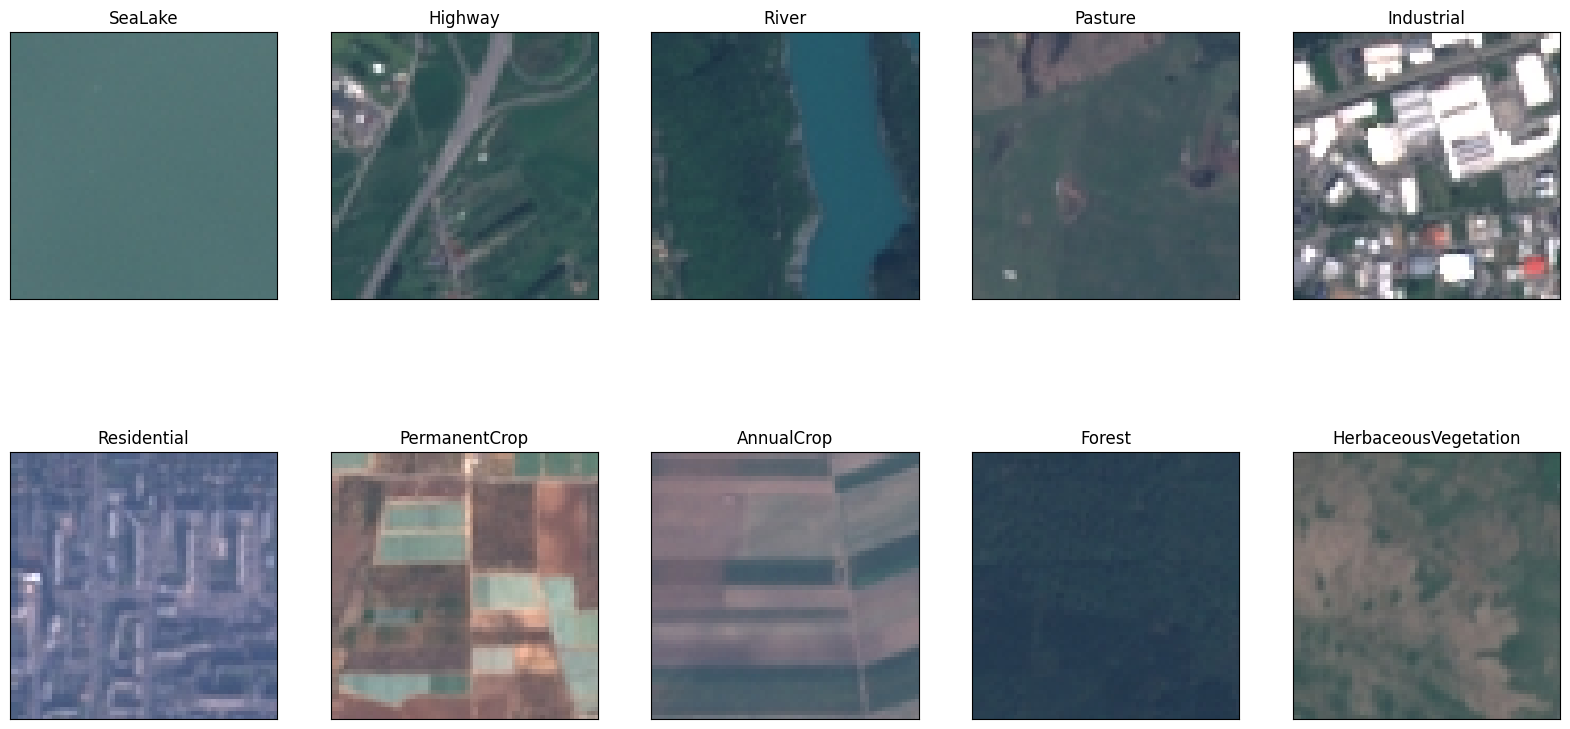

In [144]:
plt.figure(figsize=(20, 10))

for i, cls in enumerate(class_dirs[:10]):
    img_path = os.path.join(base_path, cls, random.choice(os.listdir(os.path.join(base_path, cls))))
    img = load_img(img_path, target_size=(img_height, img_width))

    plt.subplot(2, 5, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.title(cls, fontsize=12)
    plt.xticks([])
    plt.yticks([])

plt.show()


# **Early Stop Block**

In [145]:
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=10,               # stop after 10 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# **Checkpoint Folder**

In [146]:
# Create  folder to save all checkpoints
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# **CNN Model**

In [147]:
num_classes = len(train_generator.class_indices)

#Define
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.GlobalAveragePooling2D(),   
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

#Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - accuracy: 0.2613 - loss: 1.9051 - val_accuracy: 0.5015 - val_loss: 1.4236
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.5038 - loss: 1.3762 - val_accuracy: 0.6100 - val_loss: 1.1101
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.5962 - loss: 1.1362 - val_accuracy: 0.6652 - val_loss: 0.9217
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.6492 - loss: 0.9749 - val_accuracy: 0.6426 - val_loss: 0.9156
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.6669 - loss: 0.9059 - val_accuracy: 0.7017 - val_loss: 0.8269
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.6914 - loss: 0.8399 - val_accuracy: 0.7302 - val_loss: 0.7282
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 0.7144 - loss: 0.7813 - val_accuracy: 0.7463 - val_loss: 0.6710
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.7272 - loss: 0.7394 - val_accurac

### *CheckPoint*

In [148]:
# Save model to this directory
model.save("/kaggle/working/custom_model.keras", save_format='keras')

### *Classification report*

In [149]:
val_preds = model.predict(val_generator)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_labels))

169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step
                      precision    recall  f1-score   support

          AnnualCrop       0.95      0.91      0.93       600
              Forest       0.98      0.98      0.98       600
HerbaceousVegetation       0.89      0.94      0.91       600
             Highway       0.89      0.78      0.83       500
          Industrial       0.92      0.94      0.93       500
             Pasture       0.89      0.88      0.88       400
       PermanentCrop       0.82      0.89      0.86       500
         Residential       0.97      0.97      0.97       600
               River       0.87      0.88      0.87       500
             SeaLake       0.98      0.98      0.98       600

            accuracy                           0.92      5400
           macro avg       0.92      0.92      0.92      5400
        weighted avg       0.92      0.92      0.92      5400



### *Performance Analysis*

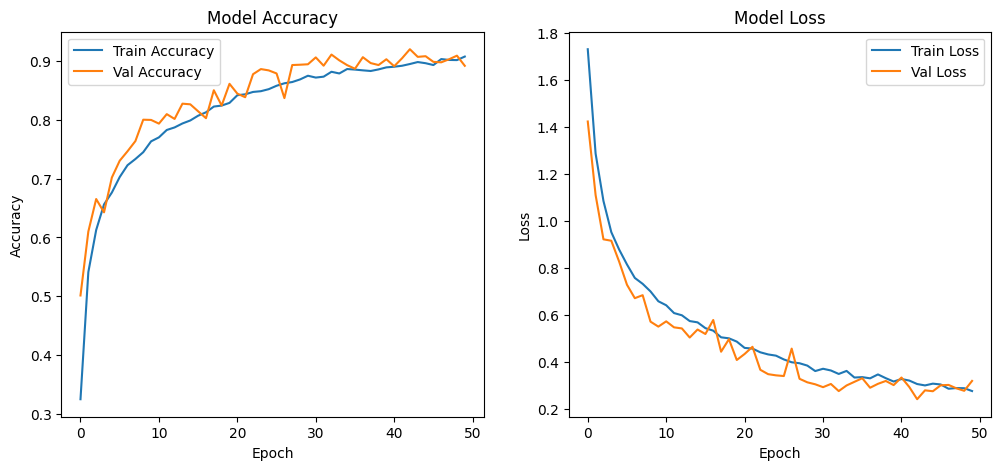

In [150]:
# Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### *Confusion Matrix*

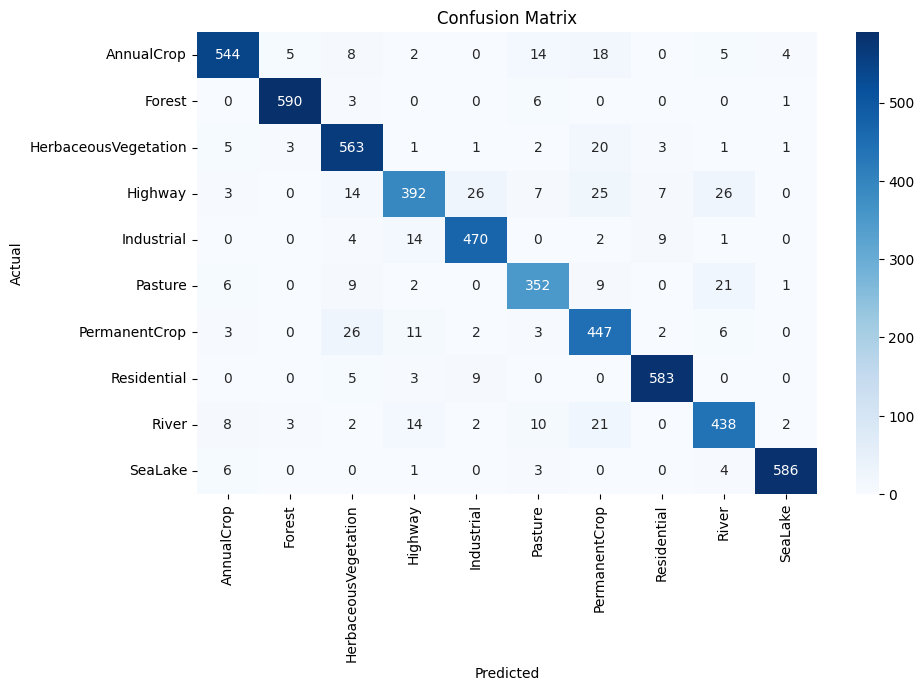

In [151]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# **Pretrained CNN ResNet50**

In [152]:

SEED = 42
tf.random.set_seed(SEED)

# Image size required for ResNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Update your datagen preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col='Filename', y_col='ClassName', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col='Filename', y_col='ClassName', target_size=IMG_SIZE,
    class_mode='categorical', batch_size=BATCH_SIZE, shuffle=False
)

# Define 
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False

resnet_model = models.Sequential([
    resnet_base,                                                               # Pretrained ResNet50 feature extractor
    layers.GlobalAveragePooling2D(),                                           # Reduces feature maps to a flat vector
    layers.Dense(128, activation='relu'),                                      # Fully connected layer to learn patterns 
    layers.Dropout(0.3),                                                       # Helps prevent overfitting
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train 
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


591/591 ━━━━━━━━━━━━━━━━━━━━ 99s 143ms/step - accuracy: 0.6637 - loss: 1.0380 - val_accuracy: 0.9304 - val_loss: 0.2329
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 75s 127ms/step - accuracy: 0.9116 - loss: 0.2823 - val_accuracy: 0.9480 - val_loss: 0.1749
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - accuracy: 0.9299 - loss: 0.2114 - val_accuracy: 0.9483 - val_loss: 0.1577
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 75s 127ms/step - accuracy: 0.9460 - loss: 0.1668 - val_accuracy: 0.9541 - val_loss: 0.1397
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - accuracy: 0.9515 - loss: 0.1493 - val_accuracy: 0.9602 - val_loss: 0.1262
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - accuracy: 0.9590 - loss: 0.1270 - val_accuracy: 0.9593 - val_loss: 0.1256
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - accuracy: 0.9644 - loss: 0.1119 - val_accuracy: 0.9624 - val_loss: 0.1145
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 76s 129ms/step - accuracy: 0.9664 - loss: 0.1040 - val

### *Classification Report*

In [153]:
true_labels = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
pred_probs = resnet_model.predict(val_generator, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
print(classification_report(true_labels, pred_labels, target_names=class_labels))

                      precision    recall  f1-score   support

          AnnualCrop       0.96      0.96      0.96       600
              Forest       0.99      0.99      0.99       600
HerbaceousVegetation       0.96      0.96      0.96       600
             Highway       0.94      0.95      0.95       500
          Industrial       0.99      0.98      0.98       500
             Pasture       0.95      0.96      0.95       400
       PermanentCrop       0.95      0.94      0.95       500
         Residential       0.99      0.99      0.99       600
               River       0.95      0.94      0.95       500
             SeaLake       1.00      0.99      0.99       600

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



### *CheckPoint*

In [154]:
# Save model to this directory
# Save pretrained model with full path and extension
model.save(("/kaggle/workingpretrained_model.keras"), save_format='keras')

# **Performance Comparison: CCNN-Custom Vs CNN-Pretrained**

In [155]:
# For Pretrained CNN
test_generator_resnet = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df, x_col='Filename', y_col='ClassName',
    target_size=(224, 224), class_mode='categorical',
    batch_size=32, shuffle=False
)

# For Custom CNN
test_generator_custom = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col='Filename', y_col='ClassName',
    target_size=(224, 224), class_mode='categorical',
    batch_size=32, shuffle=False
)

Found 2700 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Custom CNN Test Accuracy: 0.9219
Pretrained CNN Test Accuracy: 0.7619


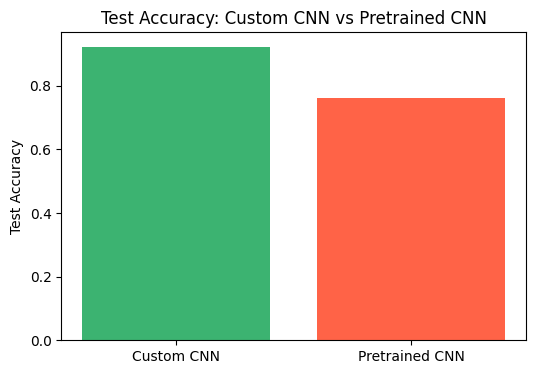

In [156]:
custom_model_path = "/kaggle/working/custom_model.keras"
pretrained_model_path = "/kaggle/working/pretrained_model.keras"


custom_model = load_model(custom_model_path)
pretrained_model = load_model(pretrained_model_path)

custom_loss, custom_acc = custom_model.evaluate(test_generator, verbose=0)
pretrained_loss, pretrained_acc = pretrained_model.evaluate(test_generator, verbose=0)


print(f"Custom CNN Test Accuracy: {custom_acc:.4f}")
print(f"Pretrained CNN Test Accuracy: {pretrained_acc:.4f}")

models = ['Custom CNN', 'Pretrained CNN']
accuracies = [custom_acc, pretrained_acc]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies, color=['mediumseagreen', 'tomato'])
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy: Custom CNN vs Pretrained CNN')
plt.show()